In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/target_visual_field.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app

In [2]:
%matplotlib notebook

In [3]:

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [4]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf

# Set responsivity filter

In [5]:
# responsive_test = 'nstds'
# responsive_thr = 10.0
# n_stds = 2.5

responsive_test = 'ROC'
responsive_thr = 0.05
n_stds = 0
response_type = 'dff'
traceid= 'traces001'

In [6]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
trace_type = optsE.trace_type
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

In [22]:
always_exclude = ['20190426_JC078']

In [7]:
stats_str = '%s-%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)

In [8]:
dsets = sdata[sdata['experiment']=='blobs']

# Set output dirs

In [9]:
outdir = os.path.join(aggregate_dir, 'linear-separability')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/linear-separability


# Load data

In [10]:
data_dir = os.path.join(aggregate_dir, 'data-stats')
os.listdir(data_dir)

load_data = False
blobsdata_outfile = os.path.join(data_dir, 'blobs_%s-%s_%s-thr-%.2f.pkl' % (traceid, response_type, responsive_test, responsive_thr))
print(blobsdata_outfile)
if os.path.exists(blobsdata_outfile):
    print("...loading data")
    with open(blobsdata_outfile, 'rb') as f:
        NEURALDATA = pkl.load(f)
else:
    load_data = True


/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05.pkl
...loading data


## Test with 1 dataset

In [11]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC099' #'JC059'
session = '20190612' #'20190227'
visual_area = 'Li'
fovnum = 1


fov = 'FOV%i_zoom2p0x' % fovnum #'FOV4_zoom4p0x'
datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

In [12]:

#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [0, 106]
restrict_transform = True
constant_transform = 'size'

C_value = 1.
m0 = 0
m100 = 106

size_colors = sns.cubehelix_palette(len(tested_sizes))
lw=2


data_id = '|'.join([animalid, session, fov, traceid, stats_str])

roi_list = [r for r in NEURALDATA[datakey]['data'].columns.tolist() if r != 'config']
sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
sample_labels = NEURALDATA[datakey]['data']['config'].copy()
sdf =  NEURALDATA[datakey]['sdf'].copy()
print(sample_data.shape)
print("N neurons: %i" % len(roi_list))

#stimdf = sdf[sdf['morphlevel'] != -1]
stimdf = sdf.copy()
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())


NameError: name 'tested_sizes' is not defined

In [64]:
#### Test linear separability
# Rust & Dicarlo, 2010.
# 80% of the trials for each trnsformation were combined and used to train; performacne asses with remaining 20%

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [13]:
C_value = 1.0
n_iterations = 50
NCELLS = 10

In [13]:
N_samples = {6, 12, 24, 48, 96, 192}

In [23]:
too_few=dict((nc, []) for nc in N_samples)

df = []
chance=[]
i = 0
for NCELLS in N_samples:

    for (animalid, session, fovnum), g in dsets[dsets['visual_area']=='Li'].groupby(['animalid', 'session', 'fovnum']):
        datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

        roi_list = np.array([r for r in NEURALDATA[datakey]['data'].columns.tolist() if r != 'config'])

        if len(roi_list) < NCELLS:
            too_few[NCELLS].append((datakey, len(roi_list)))
            continue

        results=[]; chance_results=[];
        for iteration in np.arange(0, n_iterations):
            
            roi_indices = np.arange(0, len(roi_list))
            np.random.shuffle(roi_indices)
            roi_list = roi_list[roi_indices[0:NCELLS]]

            sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
            sample_labels = NEURALDATA[datakey]['data']['config'].copy()
            sdf =  NEURALDATA[datakey]['sdf'].copy()

            # First get only Object A and B trials
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
            data = sample_data.loc[included_trial_nums]
            targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            # Equalize df/f across neurons:  Normalize each neuron to have 
            # the same (zero) mean and (unit) SD across the Ms stimuli
            zdata = (data - data.mean()) / data.std()

            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

#         results=[]; chance_results=[];
#         for iteration in np.arange(0, n_iterations):
            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            chance_train_data=[]; chance_test_data=[];
            chance_train_labels=[]; chance_test_labels=[];
            for sz in sizes:
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials]
                yi = targets.loc[curr_trials]['label'].values

                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)

                # Get chance by shuffling labes
                target_label_ixs = np.arange(0,len(yi))
                np.random.shuffle(target_label_ixs)
                rand_yi = yi[target_label_ixs]

                chance_train_x, chance_test_x, chance_train_y, chance_test_y = train_test_split(xi, rand_yi, test_size=0.2)
                print(chance_train_x.shape, chance_train_y.shape)
                print(chance_test_x.shape, chance_test_y.shape)

                chance_train_data.append(chance_train_x)
                chance_test_data.append(chance_test_x)
                chance_train_labels.append(chance_train_y)
                chance_test_labels.append(chance_test_y)

            print('---')
            train_data = np.vstack(train_data)
            train_labels = np.hstack(train_labels)
            print(train_data.shape, train_labels.shape)

            test_data = np.vstack(test_data)
            test_labels = np.hstack(test_labels)
            #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[1]))

            chance_train_data = np.vstack(chance_train_data)
            chance_train_labels = np.hstack(chance_train_labels)
            print(chance_train_data.shape, chance_train_labels.shape)

            chance_test_data = np.vstack(chance_test_data)
            chance_test_labels = np.hstack(chance_test_labels)

            #### Train SVM:
            #trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
            #train_scores.append(trained_svc.score(train_data, train_labels))

            #### Validate:
            #test_score = trained_svc.score(test_data, test_labels)  
            #crossval_scores.append(curr_score)
            #predicted_labels = trained_svc.predict(test_data)

            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())
            results.append(pd.DataFrame(iterdict, index=[iteration]))

            # Chance
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            chance_scores = cross_validate(svc, chance_train_data, chance_train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in chance_scores.items())
            chance_results.append(pd.DataFrame(iterdict, index=[iteration]))

        ddf = pd.concat(results, axis=0)
        results_across_iters = dict(ddf.mean())
        results_across_iters.update({'datakey': datakey, 'n_units': NCELLS})
        
        #ddf['datakey'] = [datakey for _ in np.arange(0, ddf.shape[0])]
        #ddf['n_units'] = [len(roi_list) for _ in np.arange(0, ddf.shape[0])]

        chance_ddf = pd.concat(chance_results, axis=0)
        chance_results_across_iters = dict(chance_ddf.mean())
        chance_results_across_iters.update({'datakey': datakey, 'n_units': NCELLS})
        #chance_ddf['datakey'] = [datakey for _ in np.arange(0, chance_ddf.shape[0])]
        #chance_ddf['n_units'] = [len(roi_list) for _ in np.arange(0, chance_ddf.shape[0])]

        df.append(pd.DataFrame(results_across_iters, index=[i]))
        chance.append(pd.DataFrame(chance_results_across_iters, index=[i]))
        i += 1
        



NameError: name 'N_samples' is not defined

In [184]:

df = pd.concat(df, axis=0)
chance = pd.concat(chance, axis=0)



In [187]:
df.groupby(['n_units']).mean()

,fit_time,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
n_units,,,,,,,,
6,0.006038,0.000433,0.537819,-5193.061988,-0.850200,0.592349,-4580.367544,-0.631803
12,0.009596,0.000466,0.529808,-5283.073519,-0.882328,0.618066,-4291.411295,-0.528905
24,0.016815,0.000837,0.543280,-5131.701712,-0.828449,0.669747,-3710.717578,-0.322066
48,0.032725,0.000806,0.557090,-4976.533706,-0.773152,0.750165,-2807.144807,-0.000123
96,0.039304,0.000921,0.565081,-4886.753664,-0.741288,0.918488,-915.868672,0.673706


In [188]:
chance.groupby(['n_units']).mean()

,fit_time,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
n_units,,,,,,,,
6,0.005940,0.000414,0.503916,-5574.000132,-0.986113,0.566647,-4869.157084,-0.734845
12,0.009624,0.000460,0.501800,-5597.774470,-0.994677,0.593262,-4570.110306,-0.628384
24,0.017591,0.000853,0.500292,-5614.721518,-1.000638,0.639259,-4053.290363,-0.444173
48,0.039193,0.000873,0.501219,-5604.301816,-0.996834,0.705762,-3306.056350,-0.177886
96,0.052637,0.000982,0.500291,-5614.725539,-1.000545,0.845927,-1731.168416,0.383240


In [211]:
train_res = np.array([(g['train_accuracy'].mean(), spstats.sem(g['train_accuracy']))\
                      for n_units, g in df.groupby(['n_units'])])
test_res = np.array([(g['test_accuracy'].mean(), spstats.sem(g['test_accuracy']))\
                     for n_units, g in df.groupby(['n_units'])])

train_chance = np.array([(g['train_accuracy'].mean(), spstats.sem(g['train_accuracy']))\
                      for n_units, g in chance.groupby(['n_units'])])
test_chance = np.array([(g['test_accuracy'].mean(), spstats.sem(g['test_accuracy']))\
                      for n_units, g in chance.groupby(['n_units'])])

N_samples = np.array([n_units for n_units, g in df.groupby(['n_units'])])

In [217]:
[t[1] for t in test_chance]

[0.0011775012021419658,
 0.0013658403429293476,
 0.001420104602711806,
 0.0013666861694844384,
 0.0028921528389125673]

<IPython.core.display.Javascript object>


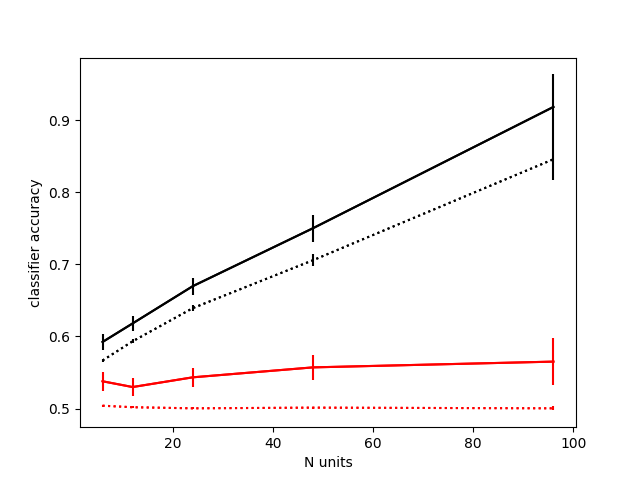

Text(0,0.5,u'classifier accuracy')

In [218]:
pl.figure()
pl.plot(N_samples, [t[0] for t in train_res], 'k-')
pl.errorbar(N_samples, [t[0] for t in train_res], yerr=[t[1] for t in train_res], color='k')

pl.plot(N_samples, [t[0] for t in train_chance], 'k:')
pl.errorbar(N_samples, [t[0] for t in train_chance], yerr=[t[1] for t in train_chance], color='k', linestyle=':')

pl.plot(N_samples, [t[0] for t in test_res], 'r-')
pl.errorbar(N_samples, [t[0] for t in test_res], yerr=[t[1] for t in test_res], color='r')

pl.plot(N_samples, [t[0] for t in test_chance], 'r:')
pl.errorbar(N_samples, [t[0] for t in test_chance], yerr=[t[1] for t in test_chance], color='r', linestyle=':')

pl.xlabel("N units")
pl.ylabel("classifier accuracy")

# Threshold RF-lum, Threshold Overlap-percentage

In [14]:
import itertools
import statsmodels as sm

def do_mannwhitney(mdf, metric='I_rs'):
    visual_areas = ['V1', 'Lm', 'Li']
    mpairs = list(itertools.combinations(visual_areas, 2))

    pvalues = []
    for mp in mpairs:
        d1 = mdf[mdf['visual_area']==mp[0]][metric]
        d2 = mdf[mdf['visual_area']==mp[1]][metric]

        # compare samples
        stat, p = spstats.mannwhitneyu(d1, d2)
        #print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
        pvalues.append(p)

    reject, pvals_corrected, _, _ = sm.stats.multitest.multipletests(pvalues, alpha=0.05, method='holm')
    results = []
    for mp, rej, pv in zip(mpairs, reject, pvals_corrected):
        results.append((mp, rej, pv))
    
    return results

## Load RF overlap metrics

In [17]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)



## Select objects to classify

In [18]:

# First get only Object A and B trials
# Pick objects based on lum-ratio criterion of >=0.8 for object pairs.

m0 = 0 #objectA
m100 = 53 #objectB #106
    

## Load luminance calculations for objects

In [19]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')
lumratios_datafile = os.path.join(luminance_dir, 'lum-ratios_M%i-M%i.pkl' % (m0, m100))
assert os.path.exists(lumratios_datafile), "LUM-RATIOS NOT FOUND."
with open(lumratios_datafile, 'rb') as f:
    lumdf = pkl.load(f)


# Set plotting params

In [24]:
visual_areas = ['V1', 'Lm', 'Li']
color_list = ['gray', 'cornflowerblue', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

# Bootstrap, simultaneously acquired

In [193]:
overlap_thr=0.20
luminance_thr=0.8
C_value = 1.0

do_correction = True
n_iterations = 50


In [29]:

i = 0
rfdf=[]
no_cells=[]
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if '%s_%s' % (session, animalid) in always_exclude:
        continue
        
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

    sdf =  NEURALDATA[datakey]['sdf'].copy()
    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
    sizes = sorted(stimdf['size'].unique())

    # Select subset of data
    sample_labels = NEURALDATA[datakey]['data']['config'].copy()
    included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
    sample_data = NEURALDATA[datakey]['data'].loc[included_trial_nums].copy()

    # Get labels
    targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
    targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

    if do_correction:
        # Get ROIs with RF fits and threshold by lum-ratio
        curr_lumdf = lumdf[lumdf['datakey']==datakey]
        rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
        meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
        lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
        pass_rois_lum = [r for r in lum_rois if r in sample_data.columns]

        # Get ROIs with RF fits and threshold by overlap-percentage
        meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
        coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
        pass_rois_overlap = [r for r in coverage_rois if r in sample_data.columns]

        print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
        curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
        print("[%s, %s] %i rois common to both." % (visual_area, datakey, len(curr_rois))) 
    else:
        curr_rois = np.array([r for r in sample_data.columns.tolist() if r != 'config'])

    NCELLS = len(curr_rois)
    if NCELLS == 0:
        no_cells.append(datakey)
        continue

    # if len(curr_rois) < NCELLS:
    #     too_few[NCELLS].append((datakey, len(roi_list)))
    #     continue

    results=[]; test_results=[];
    for iteration in np.arange(0, n_iterations):

        roi_indices = np.arange(0, len(curr_rois))
        np.random.shuffle(roi_indices)
        roi_list = curr_rois[roi_indices[0:NCELLS]]

        sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
        sample_labels = NEURALDATA[datakey]['data']['config'].copy()
        sdf =  NEURALDATA[datakey]['sdf'].copy()

        # First get only Object A and B trials
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
        data = sample_data.loc[included_trial_nums]
        targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
        targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

        # Equalize df/f across neurons:  Normalize each neuron to have 
        # the same (zero) mean and (unit) SD across the Ms stimuli
        zdata = (data - data.mean()) / data.std()

        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[]; 
        train_labels=[]; test_labels=[]; 
        chance_train_data=[]; chance_test_data=[];
        chance_train_labels=[]; chance_test_labels=[];
        for sz in sizes:
            curr_configs = sdf[sdf['size']==sz].index.tolist()
            curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
            xi = zdata.loc[curr_trials]
            yi = targets.loc[curr_trials]['label'].values
            train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
            train_data.append(train_x)
            test_data.append(test_x)
            train_labels.append(train_y)
            test_labels.append(test_y)
        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)
        #print(train_data.shape, train_labels.shape)
        test_data = np.vstack(test_data)
        test_labels = np.hstack(test_labels)
        #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[1]))

        #### Fit classifier
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())
        results.append(pd.DataFrame(iterdict, index=[iteration]))
        
        # Test with held-out data
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)  
        test_results.append(test_score)
        
    ddf = pd.concat(results, axis=0)
    results_across_iters = dict(ddf.mean())
    results_across_iters.update({'datakey': datakey, 
                            'n_units': NCELLS, 
                            'visual_area': visual_area,
                            'heldout_test_score': np.mean(test_results)})
    
    rfdf.append(pd.DataFrame(results_across_iters, index=[i]))
    i+=1

rfdf = pd.concat(rfdf, axis=0)
rfdf.shape


((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))
((240, 79), (240,))


((500, 134), (500,))
((500, 134), (500,))
((500, 134), (500,))
((500, 134), (500,))
((500, 134), (500,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (240,))
((240, 62), (24

((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((240, 69), (240,))
((234, 68), (234,))
((234, 68), (234,))
((234, 68), (234,))
((234, 68), (234,))
((234, 68), (234,))


((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 98), (240,))
((240, 45), (240,))
((240, 45), (240,))
((240, 45), (240,))
((240, 45), (240,))
((240, 45), (240,))


((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 116), (240,))
((240, 188), (240,))
((240, 188), (240,))
((240, 188), (240,))
((240, 188), (240,))
((240, 188), (240,))
((240, 188), (240,))
((240, 188), (240,))
((240, 188), 

(36, 12)

In [30]:
rfdf.groupby(['visual_area']).count()

,datakey,fit_time,heldout_test_score,n_units,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
visual_area,,,,,,,,,,,
Li,14,14,14,14,14,14,14,14,14,14,14
Lm,11,11,11,11,11,11,11,11,11,11,11
V1,11,11,11,11,11,11,11,11,11,11,11


#### Plot results

In [25]:
lumdir = os.path.join(aggregate_dir, 'luminance-analysis')

In [26]:
C_value, overlap_thr, luminance_thr

(1.0, 0.25, 0.8)

<IPython.core.display.Javascript object>


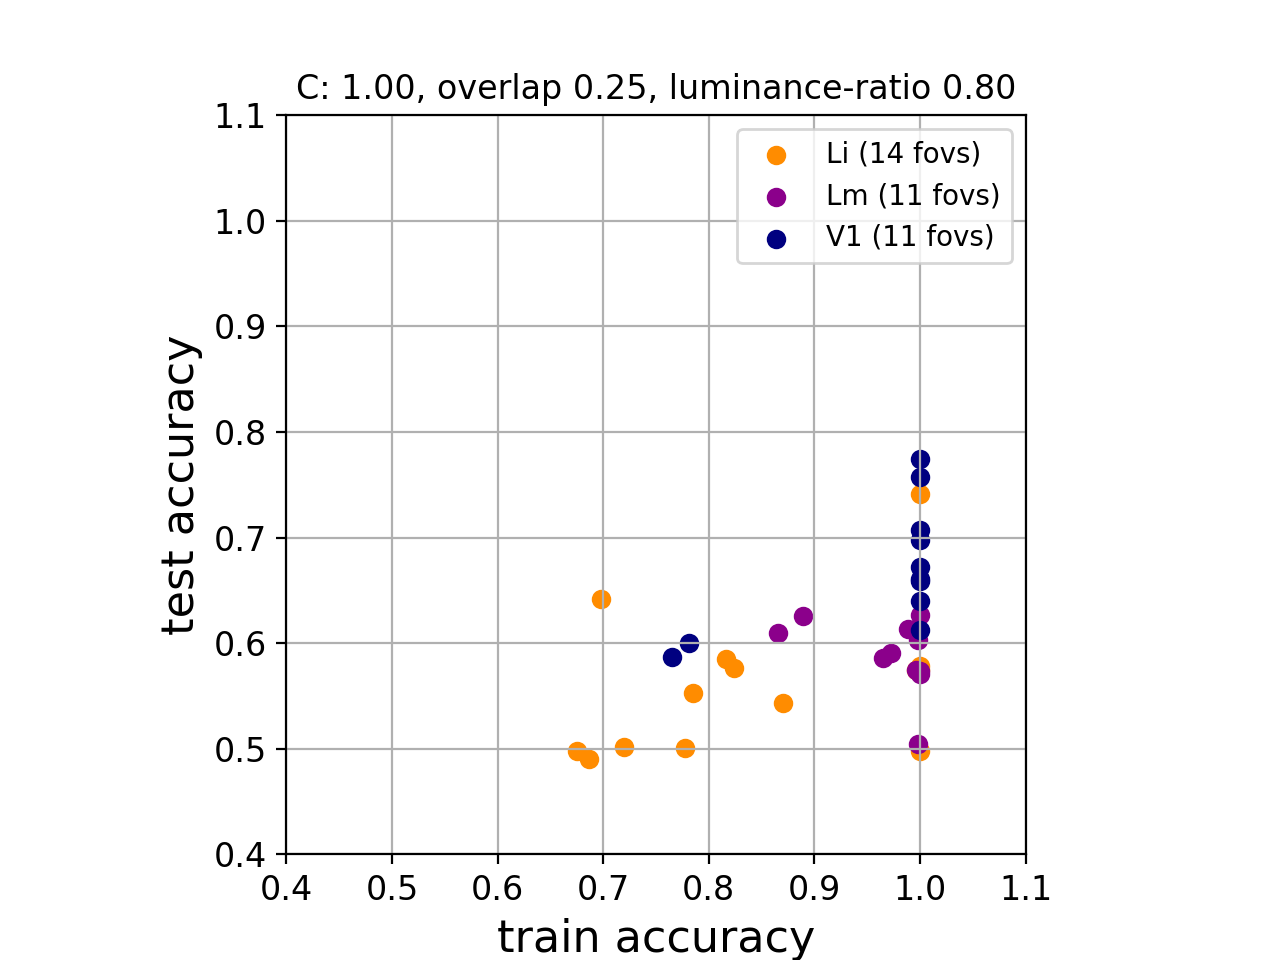

linear-sep_population-analysis_ORIG_C1.00_none


In [34]:
fig, ax = pl.subplots()
for visual_area, g in rfdf.groupby(['visual_area']):
    
    ax.scatter(g['train_accuracy'], g['test_accuracy'], color=area_colors[visual_area],
              label='%s (%i fovs)' % (visual_area, len(g['train_accuracy'])))

ax.set_title("C: %.2f, overlap %.2f, luminance-ratio %.2f" % (C_value, overlap_thr, luminance_thr))
ax.set_xlabel('train accuracy')
ax.set_ylabel('test accuracy')
ax.set_xlim([0.4, 1.1])
ax.set_ylim([0.4, 1.1])
ax.set_aspect('equal')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.0, 1))

if do_correction:
    figname = 'linear-sep_population-analysis_C%.2f_filtered-lum-%.2f-overlap-%.2f' % (C_value, luminance_thr, overlap_thr)
else:
    figname = 'linear-sep_population-analysis_C%.2f_none' % C_value
    
pl.savefig(os.path.join(lumdir, '%s.svg' % figname))
print(figname)

In [35]:
rfdf.groupby(['visual_area']).mean()

,fit_time,heldout_test_score,n_units,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
visual_area,,,,,,,,,,
Li,0.030997,0.570203,86.500000,0.000619,0.561149,-4930.926589,-0.756917,0.846406,-1725.782796,0.385135
Lm,0.023752,0.618203,99.545455,0.000665,0.589077,-4617.129670,-0.645216,0.970294,-333.780944,0.881072
V1,0.014345,0.703268,114.272727,0.000630,0.669789,-3710.254059,-0.322032,0.958737,-463.634325,0.834823


In [27]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/linear-separability'

<IPython.core.display.Javascript object>


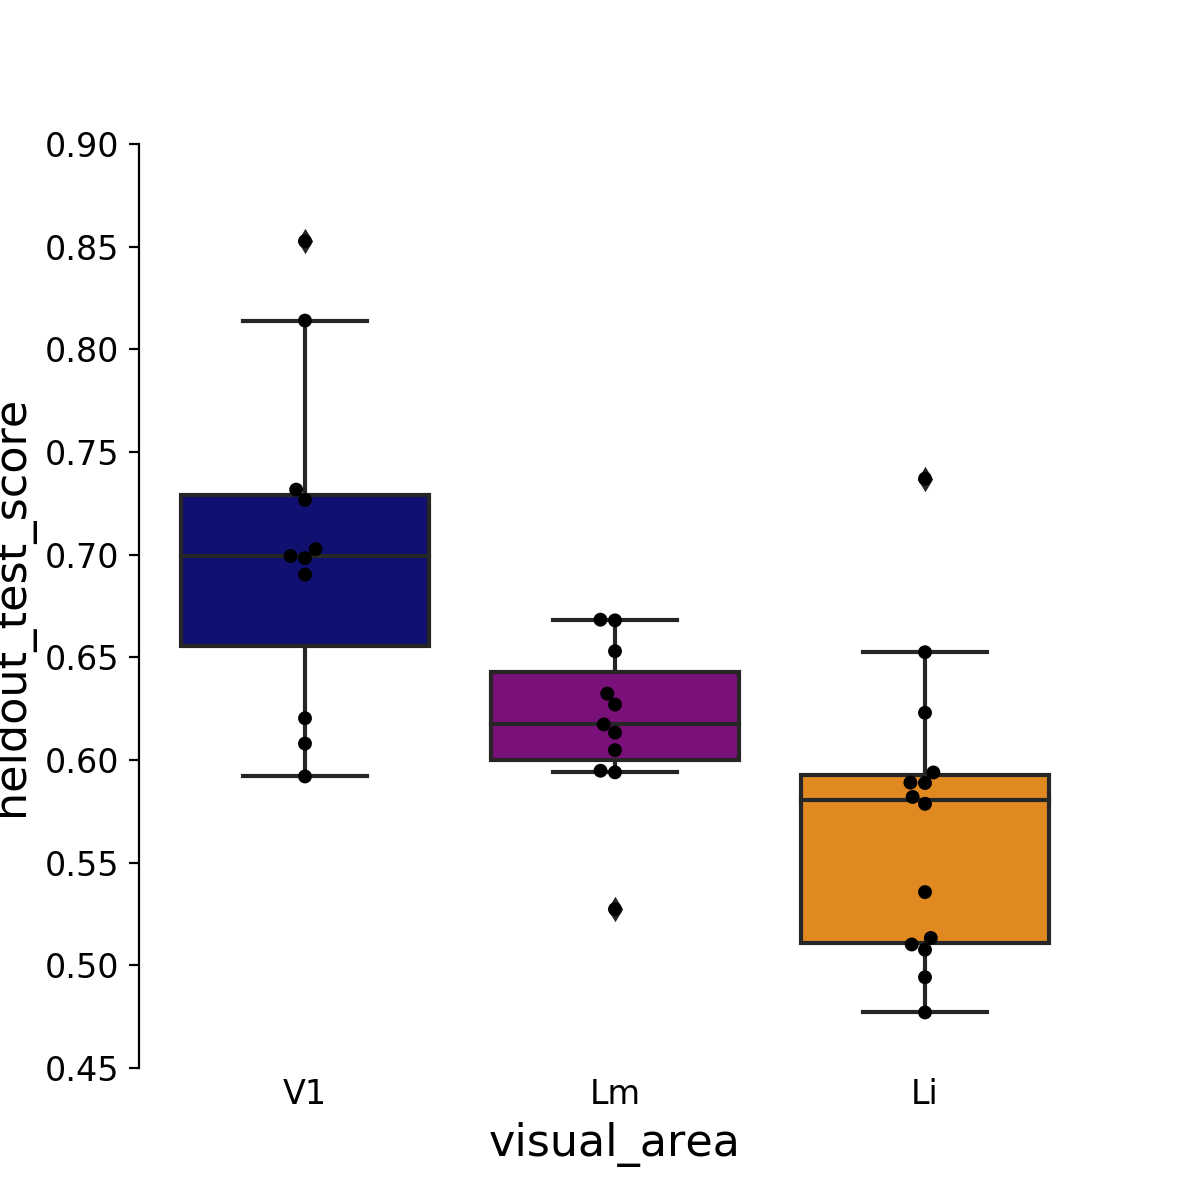

('/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis', 'mean-test-acc_ORIG_linear-sep_population-analysis__C1.00_none')


In [40]:
fig, ax = pl.subplots(figsize=(6,6))
sns.boxplot(x='visual_area', y='heldout_test_score', data=rfdf, # kind='box',
            palette=area_colors, order=visual_areas, ax=ax)
sns.swarmplot(x='visual_area', y='heldout_test_score', data=rfdf, # kind='box',
            color='k', order=visual_areas, ax=ax, alpha=1)
ax.set_ylim([0.45, 0.9])
ax.tick_params(axis='x', size=0)

sns.despine(bottom=True, offset=4)


if do_correction:
    figname = 'mean-test-acc_linear-sep_population-analysis__C%.2f_filtered-lum-%.2f-overlap-%.2f' % (C_value, luminance_thr, overlap_thr)
else:
    figname = 'mean-test-acc_ORIG_linear-sep_population-analysis__C%.2f_none' % C_value
pl.savefig(os.path.join(lumdir, '%s.svg' % figname))

print(lumdir, figname)

In [128]:
res = do_mannwhitney(rfdf, metric='heldout_test_score')
res

Different distribution (reject H0)
Different distribution (reject H0)
Different distribution (reject H0)


[(('V1', 'Lm'), True, 0.0016220041892740238),
 (('V1', 'Li'), True, 0.00017041859615215635),
 (('Lm', 'Li'), True, 0.0054539214795181644)]

In [22]:
dsets.head()

,animalid,experiment,fov,session,visual_area,fovnum
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,1
6,JC084,blobs,FOV1_zoom2p0x,20190525,Lm,1
12,JC091,blobs,FOV1_zoom2p0x,20190627,Lm,1
16,JC091,blobs,FOV1_zoom2p0x,20191008,Li,1
22,JC091,blobs,FOV1_zoom2p0x,20190607,Li,1


In [111]:
visual_areas = ['V1', 'Lm', 'Li']
color_list = ['gray', 'cornflowerblue', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

In [103]:
outdir = os.path.join(aggregate_dir, 'luminance-analysis', 'linear-separability')
if not os.path.exists(outdir):
    print('making dir...')
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis/linear-separability


# Pool cells

In [195]:
def filter_rois(dsets, NEURALDATA, lumdf, overlaprois, luminance_thr=0.8, overlap_thr=0.20):

    nocells=[]; notrials=[];
    global_rois = dict((v, []) for v in visual_areas)
    roi_counters = dict((v, 0) for v in visual_areas)
    roidf = []
    datakeys = dict((v, []) for v in visual_areas)
    
    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        roi_counter = roi_counters[visual_area]

        if '%s_%s' % (session, animalid) in always_exclude:
            continue

        datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
        datakeys[visual_area].append(datakey)

        # For now, only take dsets w/ specified N trials
        if exact_trials and NEURALDATA[datakey]['data'].shape[0] != ntrials_expected:
            print("wrong n trials (%i)" % NEURALDATA[datakey]['data'].shape[0] )
            notrials.append('%s_%s' % (visual_area, datakey))
            continue

        curr_data = NEURALDATA[datakey]['data'].copy()
        curr_data.sort_values(by='config')
        curr_rois = [int(r) for r in curr_data.columns if r != 'config']

        # Get ROIs with RF fits and threshold by lum-ratio
        curr_lumdf = lumdf[lumdf['datakey']==datakey]
        rfexp = 'rfs10' if 'rfs10' in curr_lumdf['experiment'].unique() else 'rfs'
        meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
        lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
        pass_rois_lum = [r for r in lum_rois if r in curr_rois]

        # Get ROIs with RF fits and threshold by overlap-percentage
        mean_overlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
        coverage_rois = mean_overlaps[mean_overlaps['overlap']>=overlap_thr].index.tolist()
        pass_rois_overlap = [r for r in coverage_rois if r in curr_rois]
        
        #print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
        roi_list = np.intersect1d(pass_rois_lum, pass_rois_overlap)
        #print("%i rois common to both." % len(roi_list))    
        if len(roi_list) == 0:
            nocells.append('%s_%s' % (visual_area, datakey))
            continue

        # Reindex roi ids for global
        roi_ids = [i+roi_counter for i, r in enumerate(roi_list)]
        nrs = len(roi_list)

        global_rois[visual_area].extend(roi_ids)
        roidf.append(pd.DataFrame({'roi': roi_ids,
                                   'dset_roi': roi_list,
                                   'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                   'datakey': [datakey for _ in np.arange(0, nrs)]}))

        # Update global roi id counter
        roi_counters[visual_area] += len(roi_ids)

    roidf = pd.concat(roidf, axis=0) #.groupby(['visual_area']).count()
    print("%i datasets fail all thresholds:" % len(nocells), nocells)
    for k, v in global_rois.items():
        print(k, len(v))
        
    return roidf

#### Pool cells across all FOVS that pass thresholds

In [145]:
overlap_thr=0.10
luminance_thr = 0.80

exact_trials = False
ntrials_expected=1500

print("Luminance thr:", luminance_thr)
print("Overlap thr:", overlap_thr)

roidf = filter_rois(dsets, NEURALDATA, lumdf, overlaprois, luminance_thr=luminance_thr, overlap_thr=overlap_thr)
roidf.groupby(['visual_area']).count()

('Luminance thr:', 0.8)
('Overlap thr:', 0.1)
('2 datasets fail all thresholds:', ['Li_20190422_JC076_fov1', 'Lm_20190509_JC078_fov1'])
('V1', 731)
('Lm', 202)
('Li', 169)


,datakey,dset_roi,roi
visual_area,,,
Li,169,169,169
Lm,202,202,202
V1,731,731,731


## Pooled population analysis

In [135]:
#NCELLS = [3, 6, 12, 24, 48, 76] #96, 146
#NCELLS = [3, 6, 12, 24, 48, 96, 146]
#NCELLS = [3, 6, 12, 24, 48, 94]
#NCELLS = [3, 6, 12, 24, 39]
#NCELLS = [3, 6, 12, 15]


In [149]:
# Set levels of NCELLS to test for each overlap-thr level
ncells_dict = {0.1: [3, 6, 12, 24, 48, 96, 169],
               0.2: [3, 6, 12, 24, 48, 96, 146],
               0.3: [3, 6, 12, 24, 48, 94],
               0.4: [3, 6, 12, 24, 39],
               0.5: [3, 6, 12, 15]}

n_iterations = 50
expected_ntrials = 1500

In [207]:
analysis_str = '%i-iters_C%.2f_filtered-lum-%.2f_compare-overlaps' % (n_iterations, C_value, luminance_thr)
dfile_name = 'pooled-populations_M%i-v-M%i_acc-v-nunits__%s' % (m0, m100, analysis_str)
pooled_dfile = os.path.join(outdir, '%s.pkl' % dfile_name)
pooled_chance_dfile = os.path.join(outdir, '%s_chance.pkl' % dfile_name)

load_popdata = False
if os.path.exists(pooled_dfile):
    with open(pooled_dfile, 'rb') as f:
        popdf = pkl.load(f)
else:
    load_popdata = True
print(load_popdata)

False


In [208]:
load_popdata = True

In [209]:
if load_popdata:
    
    popdf = []
    popdf_chance = []
    i = 0
    for overlap_thr, NCELLS in ncells_dict.items():

        # Get list of eligible cells from all FOVs
        roidf = filter_rois(dsets, NEURALDATA, lumdf, overlaprois, luminance_thr=luminance_thr, overlap_thr=overlap_thr)

        for curr_ncells in NCELLS:

            for visual_area, vgroup in roidf.groupby(['visual_area']):
                print("[Overlap %.2f - %i cells in popn:\n... ... %s (%i)" % (overlap_thr, curr_ncells, visual_area, len(vgroup['roi'].unique())))

                iter_results=[]; iter_test_results=[];
                iter_results_chance=[]; iter_test_results_chance=[];
                for iteration in np.arange(0, n_iterations):

                    # Get random selection of NCELLS for current iter
                    curr_rids = sorted(vgroup['roi'].values)
                    np.random.shuffle(curr_rids)
                    curr_roi_list = curr_rids[0:curr_ncells]
                    curr_roidf = vgroup[vgroup['roi'].isin(curr_roi_list)]

                    # Make sure equal num trials per condition for all dsets
                    if not exact_trials:
                        # get fewest total n trials among dsets
                        fewest_ntrials = np.min([NEURALDATA[k]['data'].shape[0] for k in curr_roidf['datakey'].unique()])
                        # get trial counts per cond for dset w. fewest trials
                        min_ntrials = []
                        keys_with_few = [k for k in curr_roidf['datakey'].unique() if NEURALDATA[k]['data'].shape[0]==fewest_ntrials]
                        for k in keys_with_few:
                            currd = NEURALDATA[k]['data'].sort_values(by='config') #[dgroup['dset_roi']]
                            min_ntrials.append(currd.groupby(['config']).count().min().min())
                        # set min N trials per condition
                        min_ntrials = min(min_ntrials)

                    # Get data samples for these cells
                    curr_data = []
                    for datakey, dgroup in curr_roidf.groupby(['datakey']):
                        currd = NEURALDATA[datakey]['data'].sort_values(by='config') #[dgroup['dset_roi']]
                        min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                        if exact_trials:
                            tmp_d = currd.copy()
                        else:
                            # get subset of trials per cond to match min N trials
                            tmp_d=[]
                            for cfg, dmat in currd.groupby(['config']):
                                if dmat.shape[0] == min_ntrials:
                                    tmp_d.append(dmat)
                                else:
                                    tixs = np.arange(0, dmat.shape[0])
                                    np.random.shuffle(tixs)
                                    currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                                    tmp_d.append(currd_subset)
                            tmp_d = pd.concat(tmp_d, axis=0) # print(np.unique(tmp_d.groupby(['config']).count()))
                        config_list = tmp_d['config'].values # Get configs on selected trials
                        currd = tmp_d[dgroup['dset_roi']]    # Data should only include ROI columns
                        currd = currd.reset_index(drop=True) # Reset trial indices 
                        currd.columns = dgroup['roi'].values # Rename ROI columns to global-rois
                        curr_data.append(currd)
                    curr_data = pd.concat(curr_data, axis=1)
                    curr_data['config'] = config_list 

                    #### Select train/test configs for clf A vs B
                    sdf =  NEURALDATA[datakey]['sdf'].copy()
                    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
                    curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
                    sample_data = curr_data[curr_data['config'].isin(object_configs)]

                    #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
                    data = sample_data[curr_roi_list]
                    zdata = (data - data.mean()) / data.std()

                    #### Get labels
                    targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
                    targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

                    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
                    sizes = sorted(stimdf['size'].unique())

                    #### For each transformation, split trials into 80% and 20%
                    train_data=[]; test_data=[]; 
                    train_labels=[]; test_labels=[]; 
                    train_data_chance=[]; test_data_chance=[]; 
                    train_labels_chance=[]; test_labels_chance=[]; 
                    for sz in sizes: 
                        curr_configs = sdf[sdf['size']==sz].index.tolist()
                        curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                        xi = zdata.loc[curr_trials]
                        yi = targets.loc[curr_trials]['label'].values
                        
                        # Split train/test
                        train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                        train_data.append(train_x)
                        test_data.append(test_x)
                        train_labels.append(train_y)
                        test_labels.append(test_y)
                        
#                         # Create shuffled set
#                         np.random.shuffle(yi)
#                         train_x_chance, test_x_chance, train_y_chance, test_y_chance = train_test_split(xi, yi, test_size=0.2)
#                         train_data_chance.append(train_x_chance)
#                         test_data_chance.append(test_x_chance)
#                         train_labels_chance.append(train_y_chance)
#                         test_labels_chance.append(test_y_chance)
                    
                    # aggregate TRAIN/TEST data        
                    train_data = np.vstack(train_data)
                    train_labels = np.hstack(train_labels)
                    test_data = np.vstack(test_data)
                    test_labels = np.hstack(test_labels)
                    #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[0]))

                    # aggregate CHANCE data # Create shuffled set
#                     train_data_chance = train_data.copy()
#                     train_labels_chance = np.hstack(train_labels_chance)
#                     test_data_chance = np.vstack(test_data_chance)
#                     test_labels_chance = np.hstack(test_labels_chance)

                    #### DATA - Fit classifier
                    svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
                    scores = cross_validate(svc, train_data, train_labels, cv=5,
                                            scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                            return_train_score=True)
                    iterdict = dict((s, values.mean()) for s, values in scores.items())
                    iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

                    # DATA - Test with held-out data
                    trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
                    test_score = trained_svc.score(test_data, test_labels)  
                    iter_test_results.append(test_score)

                    # ---- chance ----------------------
                    train_labels_chance = train_labels.copy()
                    np.random.shuffle(train_labels_chance)
                    test_labels_chance = test_labels.copy()
                    np.random.shuffle(test_labels_chance)
                    
                    #### CHANCE - Fit classifier
                    svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
                    scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                            scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                            return_train_score=True)
                    iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())
                    iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

                    # CHANCE - Test with held-out data
                    trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
                    test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  
                    iter_test_results_chance.append(test_score_chance)

                # DATA - get mean across iters
                iter_results = pd.concat(iter_results, axis=0)
                iterdict = dict(iter_results.mean())
                iterdict.update({'n_units': curr_ncells, 
                                 'overlap': overlap_thr,
                                    'visual_area': visual_area,
                                    'heldout_test_score': np.mean(iter_test_results),
                                    'heldout_test_sem': spstats.sem(iter_test_results),
                                    'heldout_test_std': np.std(iter_test_results)})
                popdf.append(pd.DataFrame(iterdict, index=[i]))
                
                # CHANCE - get mean across iters
                iter_results_chance = pd.concat(iter_results_chance, axis=0)
                iterdict_chance = dict(iter_results_chance.mean())
                iterdict_chance.update({'n_units': curr_ncells, 
                                        'overlap': overlap_thr,
                                        'visual_area': visual_area,
                                        'heldout_test_score': np.mean(iter_test_results_chance),
                                        'heldout_test_sem': spstats.sem(iter_test_results_chance),
                                        'heldout_test_std': np.std(iter_test_results_chance)})
                popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
                i+=1

    popdf = pd.concat(popdf, axis=0)

    popdf_chance = pd.concat(popdf_chance, axis=0)
    popdf.shape, popdf_chance.shape

    # save
    with open(pooled_dfile, 'wb') as f:
        pkl.dump(popdf, f, protocol=pkl.HIGHEST_PROTOCOL)
    with open(pooled_chance_dfile, 'wb') as f:
        pkl.dump(popdf_chance, f, protocol=pkl.HIGHEST_PROTOCOL)


('5 datasets fail all thresholds:', ['Li_20190422_JC076_fov1', 'Li_20190605_JC090_fov1', 'Li_20191105_JC117_fov1', 'Lm_20190504_JC078_fov1', 'Lm_20190509_JC078_fov1'])
('V1', 668)
('Lm', 95)
('Li', 39)
[Overlap 0.40 - 3 cells in popn:
... ... Li (39)
[Overlap 0.40 - 3 cells in popn:
... ... Lm (95)
[Overlap 0.40 - 3 cells in popn:
... ... V1 (668)
[Overlap 0.40 - 6 cells in popn:
... ... Li (39)
[Overlap 0.40 - 6 cells in popn:
... ... Lm (95)
[Overlap 0.40 - 6 cells in popn:
... ... V1 (668)
[Overlap 0.40 - 12 cells in popn:
... ... Li (39)
[Overlap 0.40 - 12 cells in popn:
... ... Lm (95)
[Overlap 0.40 - 12 cells in popn:
... ... V1 (668)
[Overlap 0.40 - 24 cells in popn:
... ... Li (39)
[Overlap 0.40 - 24 cells in popn:
... ... Lm (95)
[Overlap 0.40 - 24 cells in popn:
... ... V1 (668)
[Overlap 0.40 - 39 cells in popn:
... ... Li (39)
[Overlap 0.40 - 39 cells in popn:
... ... Lm (95)
[Overlap 0.40 - 39 cells in popn:
... ... V1 (668)
('7 datasets fail all thresholds:', ['Li_20190422

In [211]:
print(popdf.shape, popdf_chance.shape)
popdf.head()

((87, 14), (87, 14))


,fit_time,heldout_test_score,heldout_test_sem,heldout_test_std,n_units,overlap,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,visual_area
0,0.003782,0.518879,0.009528,0.066695,3,0.4,0.000340,0.529240,-1322.366209,-0.884289,0.565158,-1221.471285,-0.740404,Li
1,0.003946,0.567733,0.010897,0.076281,3,0.4,0.000339,0.565696,-1219.958846,-0.738778,0.595321,-1136.743992,-0.620081,Lm
2,0.003266,0.581667,0.011569,0.080984,3,0.4,0.000336,0.578790,-1183.179296,-0.686461,0.608603,-1099.435529,-0.566995,V1
3,0.004807,0.541348,0.010858,0.076007,6,0.4,0.000338,0.549324,-1265.949255,-0.804902,0.599353,-1125.417507,-0.604391,Li
4,0.005318,0.599333,0.013323,0.093262,6,0.4,0.000339,0.588199,-1156.749330,-0.648565,0.631525,-1035.045005,-0.475001,Lm


#### Save

In [201]:
analysis_str = '%i-iters_C%.2f_filtered-lum-%.2f_compare-overlaps' % (n_iterations, C_value, luminance_thr)
dfile_name = 'pooled-populations_M%i-v-M%i_acc-v-nunits__%s' % (m0, m100, analysis_str)
pooled_dfile = os.path.join(outdir, '%s.pkl' % dfile_name)

print(pooled_dfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis/linear-separability/pooled-populations_M0-v-M53_acc-v-nunits__50-iters_C1.00_filtered-lum-0.80_compare-overlaps.pkl


In [203]:
with open(pooled_dfile, 'wb') as f:
    pkl.dump(popdf, f, protocol=pkl.HIGHEST_PROTOCOL)
    

#### Plot results

<IPython.core.display.Javascript object>


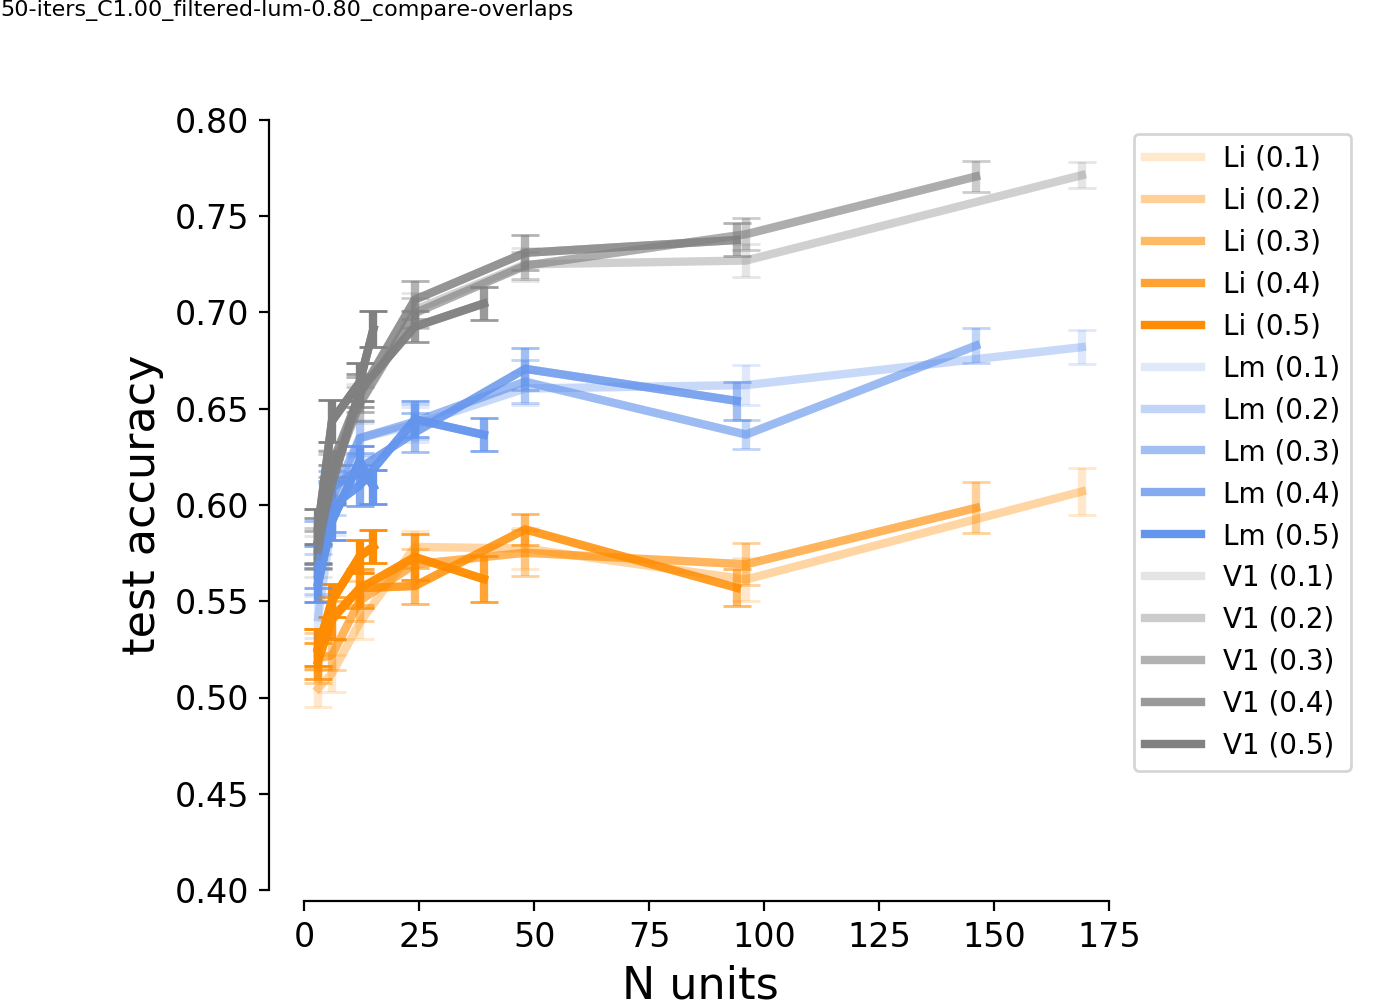

lin-sep_pooled-populations_M0-v-M53_acc-v-nunits__50-iters_C1.00_filtered-lum-0.80_compare-overlaps


In [228]:
overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))
lw = 3

fig, ax = pl.subplots(figsize=(7,5))
for visual_area, pgroup in popdf.groupby(['visual_area']):
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')['heldout_test_score']
        std_scores = g.sort_values(by='n_units')['heldout_test_sem']
        n_units_per = g.groupby(['n_units'])['heldout_test_score'].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%s (%.1f)' % (visual_area, overlap_l))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capsize=5, label=None, alpha=overlap_alphas[overlap_l], lw=lw)
ax.legend(bbox_to_anchor=(1.0, 1))
    
# for visual_area, pgroup in popdf_chance.groupby(['visual_area']):
#     for overlap_l, g in pgroup.groupby(['overlap']):
#         mean_scores = g.sort_values(by='n_units')['heldout_test_score']
#         std_scores = g.sort_values(by='n_units')['heldout_test_sem']
#         n_units_per = g.groupby(['n_units'])['heldout_test_score'].mean().index.tolist()
#         ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], linestyle=':',
#                 alpha=overlap_alphas[overlap_l], lw=lw, label=None)
#         ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], linestyle=':',
#                     capsize=5, label=None, alpha=overlap_alphas[overlap_l], lw=lw)

ax.set_xlabel("N units")
ax.set_ylabel("test accuracy")
ax.set_ylim([0.4, 0.8])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.8, left=0.2)

#analysis_str = '%i-iters_C%.2f_filtered-lum-%.2f_compare-overlaps' % (n_iterations, C_value, luminance_thr)
label_figure(fig, analysis_str)
   

figname = 'lin-sep_%s' % dfile_name
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

print(figname)

#### Plot chance

<IPython.core.display.Javascript object>


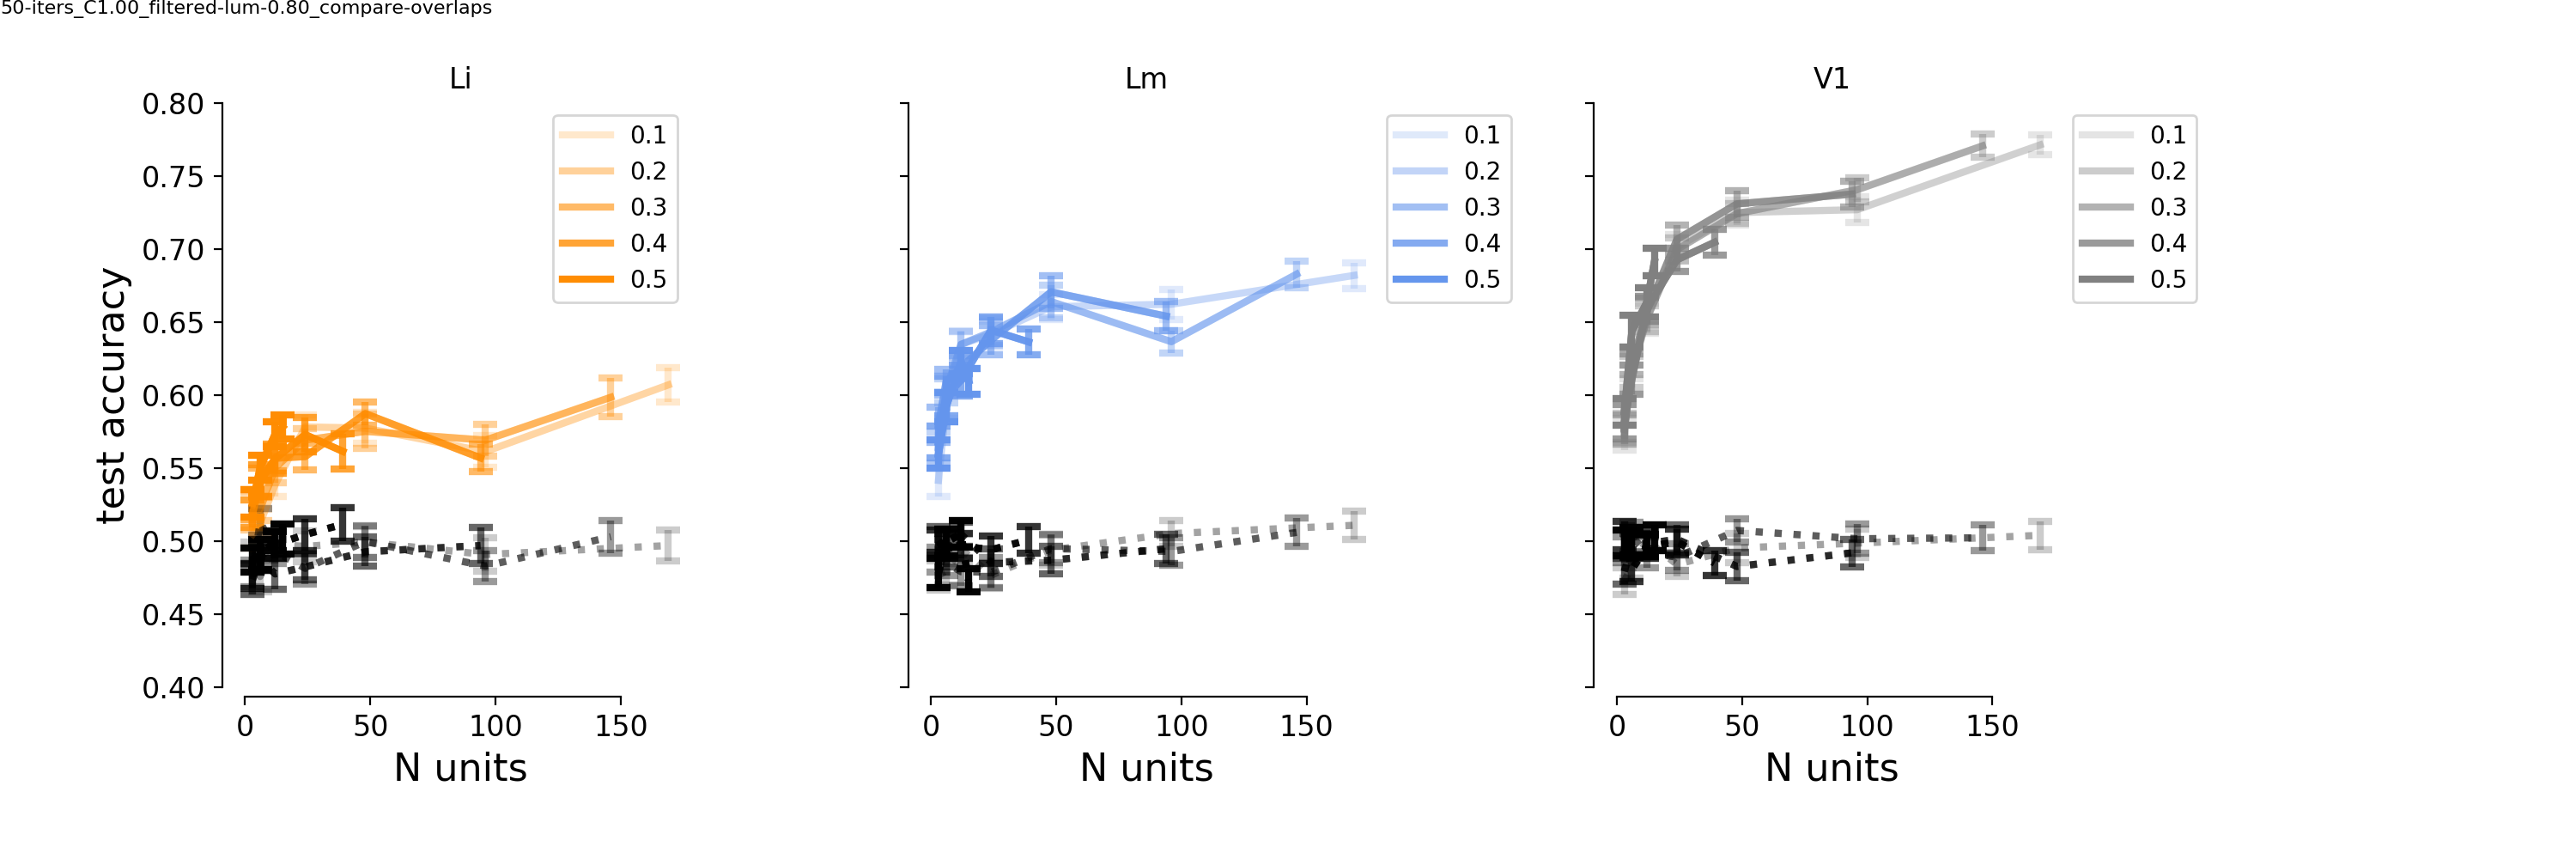

lin-sep_pooled-populations_M0-v-M53_acc-v-nunits__50-iters_C1.00_filtered-lum-0.80_compare-overlaps_CHANCE


In [262]:
overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))
lw = 3

fig, axes = pl.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ai = 0
for visual_area, pgroup in popdf.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')['heldout_test_score']
        std_scores = g.sort_values(by='n_units')['heldout_test_sem']
        n_units_per = g.groupby(['n_units'])['heldout_test_score'].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%.1f' % (overlap_l))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=5, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw)
    if ai==0:
        ax.set_ylabel("test accuracy")
    
    ax.legend(bbox_to_anchor=(1.0, 1))
    ax.set_title(visual_area)
    ai += 1
    ax.set_xlabel("N units")

ai=0
for visual_area, pgroup in popdf_chance.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')['heldout_test_score']
        std_scores = g.sort_values(by='n_units')['heldout_test_sem']
        n_units_per = g.groupby(['n_units'])['heldout_test_score'].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color='k', #area_colors[visual_area], 
                    capthick=lw, capsize=5, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
        
    ai += 1
    
ax.set_ylim([0.4, 0.8])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.8, left=0.09, wspace=0.5, bottom=0.2)

#analysis_str = '%i-iters_C%.2f_filtered-lum-%.2f_compare-overlaps' % (n_iterations, C_value, luminance_thr)
label_figure(fig, analysis_str)
   

figname = 'lin-sep_%s_CHANCE' % dfile_name
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

print(figname)

<IPython.core.display.Javascript object>


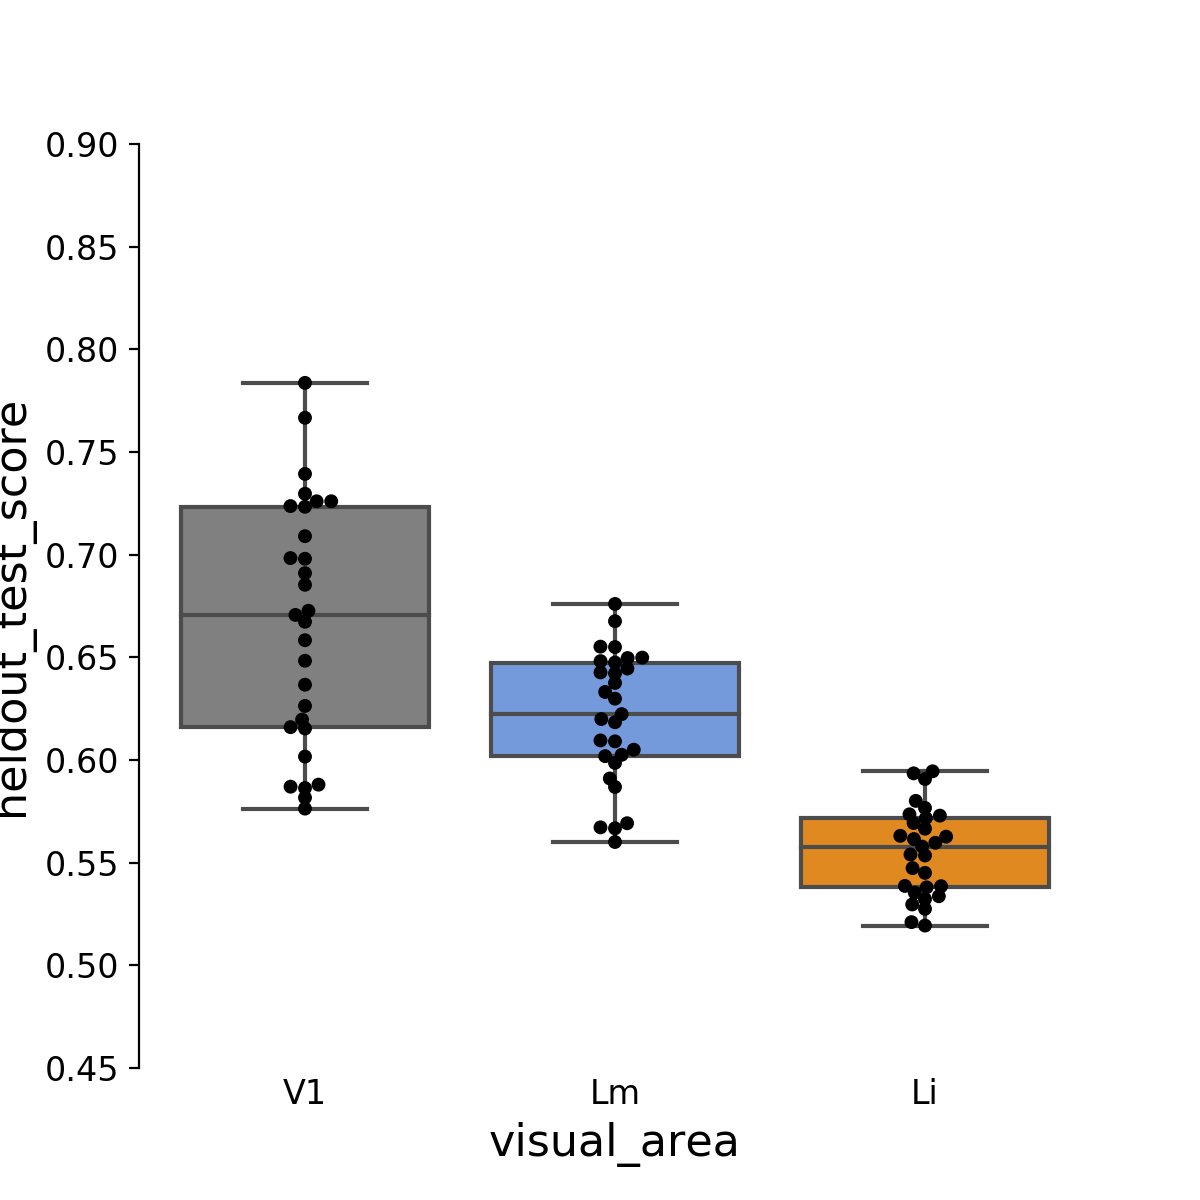

In [206]:
fig, ax = pl.subplots(figsize=(6,6))
sns.boxplot(x='visual_area', y='heldout_test_score', data=popdf, # kind='box',
            palette=area_colors, order=visual_areas, ax=ax)
sns.swarmplot(x='visual_area', y='heldout_test_score', data=popdf, # kind='box',
            color='k', order=visual_areas, ax=ax, alpha=1)
ax.set_ylim([0.45, 0.9])
ax.tick_params(axis='x', size=0)

sns.despine(bottom=True, offset=4)


# if do_correction:
#     figname = 'mean-test-acc_linear-sep_population-analysis__C%.2f_filtered-lum-%.2f-overlap-%.2f' % (C_value, luminance_thr, overlap_thr)
# else:
#     figname = 'mean-test-acc_ORIG_linear-sep_population-analysis__C%.2f_none' % C_value
# pl.savefig(os.path.join(lumdir, '%s.svg' % figname))

# print(lumdir, figname)

In [159]:
test_acc_shuff

array([ 0.50139083,  0.50329157,  0.50544713,  0.50247582,  0.49863035,
        0.49396038,  0.50136633,  0.50854252,  0.49526806,  0.51705726,
        0.50207414,  0.49547717,  0.4965973 ,  0.50682371])

#### Chnce performance?

In [133]:
chance = []
for (animalid, session, fovnum), g in dsets[dsets['visual_area']=='Li'].groupby(['animalid', 'session', 'fovnum']):
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])

    roi_list = [r for r in NEURALDATA[datakey]['data'].columns.tolist() if r != 'config']
    sample_data = NEURALDATA[datakey]['data'][roi_list].copy()
    sample_labels = NEURALDATA[datakey]['data']['config'].copy()
    sdf =  NEURALDATA[datakey]['sdf'].copy()

    # First get only Object A and B trials
    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
    data = sample_data.loc[included_trial_nums]
    targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
    targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

    # Equalize df/f across neurons:  Normalize each neuron to have 
    # the same (zero) mean and (unit) SD across the Ms stimuli
    zdata = (data - data.mean()) / data.std()

    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
    sizes = sorted(stimdf['size'].unique())

    results=[]
    for iteration in np.arange(0, n_iterations):
        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[];
        train_labels=[]; test_labels=[];
        for sz in sizes:
            curr_configs = sdf[sdf['size']==sz].index.tolist()
            curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
            xi = zdata.loc[curr_trials]
            yi = targets.loc[curr_trials]['label'].values
            np.random.shuffle(yi)

            train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)

            train_data.append(train_x)
            test_data.append(test_x)
            train_labels.append(train_y)
            test_labels.append(test_y)

        train_data = np.vstack(train_data)
        train_labels = np.hstack(train_labels)

        test_data = np.vstack(test_data)
        test_labels = np.hstack(test_labels)
        #print("%i training samples, %i test samples." % (train_data.shape[0], test_data.shape[1]))

        #### Train SVM:
        #trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        #train_scores.append(trained_svc.score(train_data, train_labels))

        #### Validate:
        #test_score = trained_svc.score(test_data, test_labels)  
        #crossval_scores.append(curr_score)
        #predicted_labels = trained_svc.predict(test_data)

        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())
        results.append(pd.DataFrame(iterdict, index=[iteration]))
    
    ddf = pd.concat(results, axis=0)
    ddf['datakey'] = [datakey for _ in np.arange(0, ddf.shape[0])]
    ddf['n_units'] = [len(roi_list) for _ in np.arange(0, ddf.shape[0])]
    chance.append(ddf)

In [134]:
chance = pd.concat(chance, axis=0)


<IPython.core.display.Javascript object>


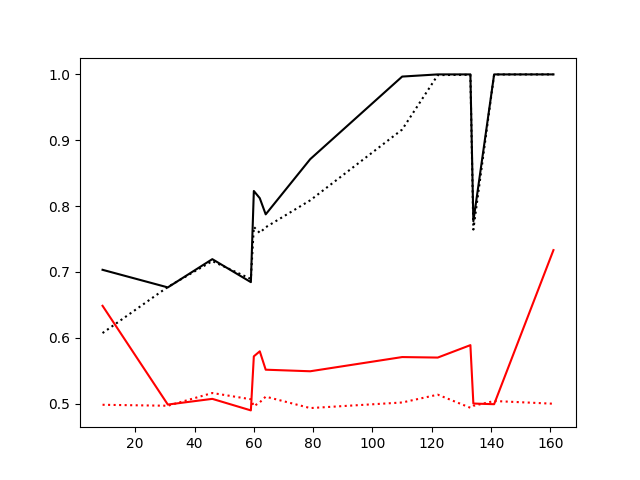

In [135]:
num_cells = df.groupby(['datakey']).mean()['n_units'].values
test_acc = df.groupby(['datakey']).mean()['test_accuracy'].values
train_acc = df.groupby(['datakey']).mean()['train_accuracy'].values
sort_ixs = np.argsort(num_cells)

fig, ax = pl.subplots()
ax.plot(num_cells[sort_ixs], test_acc[sort_ixs], label='test', color='r')
ax.plot(num_cells[sort_ixs], train_acc[sort_ixs], label='train', color='k')

num_cells_shuff = chance.groupby(['datakey']).mean()['n_units'].values
test_acc_shuff = chance.groupby(['datakey']).mean()['test_accuracy'].values
train_acc_shuff = chance.groupby(['datakey']).mean()['train_accuracy'].values
sort_ixs_shuff = np.argsort(num_cells_shuff)

ax.plot(num_cells_shuff[sort_ixs_shuff], test_acc_shuff[sort_ixs_shuff], 
        label='test-shuffled', color='r', linestyle=':')
ax.plot(num_cells_shuff[sort_ixs_shuff], train_acc_shuff[sort_ixs_shuff], 
        label='train-shuffled', color='k', linestyle=':')


In [139]:
df[df['n_units']>=60].mean()

fit_time                           0.038771
score_time                         0.000906
test_accuracy                      0.571392
test_neg_mean_squared_error    -4815.837236
test_r2                           -0.715991
train_accuracy                     0.906727
train_neg_mean_squared_error   -1048.015660
train_r2                           0.626621
n_units                          106.600000
dtype: float64